In [31]:
from abc import ABC, abstractmethod
import pandas as pd 
import numpy as np 
import yfinance as yf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
class EVDStrategyBacktest(ABC):
    
    @abstractmethod
    def process(self):
        pass
    
    @abstractmethod
    def openPosition(self):
        pass
    
    @abstractmethod
    def closePosition(self):
        pass
    
    @abstractmethod
    def monitorPosition(self):
        pass
    
    @abstractmethod
    def updatedCash(self):
        pass
    
    @abstractmethod
    def totalUnits(self):
        pass
    
    @abstractmethod
    def backtest(self):
        """Simulate the price and all the required input data in this function row by row of a 
        Pandas dataframe. On each day call: 
            - process() to initialise new positions
            - updatePositions() to monitor and close current open positions
            """
        pass

In [24]:
class BullHighBreakout(EVDStrategyBacktest):
    
    """
    This is an example of an Event Driven Strategy to back-test to. Positions will be taken and closed 
    based on price series data. 
    5% (variable) positions of the overall cash are taken when the close price is greater than the
    200 day MA and less than the 7 Day MA.  
    
    Input data columns should contain:
    - MLTI: Medium-Long Term Indicator
    - STTI: Short Term Trade Indicator
    - Target: A value for which a trade opened on that particular day is trying to exit at 
    - Price: Current Day's Close Price on which analysis is being taken - "process price"
    - Date: Current Date
    - NDOPen: Next Day Open - the price on which any trade decisions will be taken - "purchase price"
    - NDDate: Next Day's date: used to store the date of the next day (the day any trade decisions take place)
    """
    
    def __init__(self, data, start_cash, tc, cash_buffer=0):
        self.data = data # storing the data as a class variable
        self.start_cash = int(start_cash) # storing a specific variable for starting cash
        self.cash_available = start_cash # storing starting cash in a constantly updated variable
        self.cash_buffer = int(cash_buffer*self.start_cash) # option buffer amount
        self.cash_time_series = np.array([float(start_cash)]) # initialises a time series of the internal portfolio's cash value
        self.openPositions = list() # or can make this dictionary (?) with date timestamp as key
        self.closedPositions = list() # or can make this dictionary (?) with date timestamp as key
        self.tc = tc # transaction costs
        
    def process(self, data):
        """
        Takes input data which includes: 
        - a Medium to Long Term Indicator (MLTI)
        - a Short Term Trend Indicator (STTI)
        
        in a pandas Dataframe.
        
        This function runs through the logic behind initialising a trade for this strategy. 
        The variable MTLI is a 200 day MA. The variable STTI is a 7 day MA. 
        
        The Logic for opening positions:
        
        - If the price is greater than the MLTI, we proceed
        - If the price is below the 7 day MA (trending low), proceed 
        - If cash after position opens is greater than buffer: 
            - return num_units: indicating output of the decision process is positive, open a position with number
            of units equal to num_units in backtest()
        """
        
        # long term condition satisfied e.g > 200 day MA
        if data.Price.values > data["MLTI"].values:
            
            # short term condition satisfied: < e.g < 7 day MA
            if data.Price.values < data["STTI"].values:
                
                # calculate number of units
                num_units = int(np.floor((0.05 * self.cash_available) / data.Price.values[0]))
                
                # cash check - acts as a lid on opening new positions
                if (self.cash_available - num_units*data.Price.values[0]) > self.cash_buffer:
                    
                    return num_units
                
                else:
                    return 0
            
        return 0

    
    def monitorPosition(self, data, position):
        """
        Takes input of price and position to monitor. Checks if current price is greater than the target price of 
        the position. 
        
        Requires input of:
            - position to monitor
            - current price (in the "data" variable - data variable contains row of that day's
            new data)
            
        The output of running this function is: 
            - True if the position has hit it's target and needs to be closed
            - False if the position has not hit it's target and must remain open
        """
        
                
        # checking if current price is greater than the position's target
        if data.Price.values > position.Target.values:
                    
            # return once all positions are iterated through
            return True
        
        else:
            return False

    
    def backtest(self):
        """
        This function simulates the actions taken on each respective day of the trading strategy.
        The variable "data_row" contains all the necessary trading information to take a decision
        each day. 
        
        Transaction costs are applied in this function depending on whether they are greater than or
        less than 1; the former treated as absolute, the latter as a %. 
        
        Trades Initialised -> Trades Monitored/Updated -> Cash Value Updated
        """
        
        # running through each day with all available information required in data_row
        for i in range(0, len(self.data)):
            
            # all data required for that day's trade processing
            data_row = self.data.iloc[i:i+1, :]
            
            # 1 TRADE INITIALISATION: if a trade is to be placed
            if self.process(data_row) is not 0:
                
                # obtain number of units
                num_units = self.process(data_row)
                
                # open a position
                self.openPositions.append(self.openPosition(data_row.NDOpen.values, num_units, data_row.NDDate.values, data_row.Target.values))
                
                # reducing the portfolio's cash
                if self.tc >= 1:
                    self.cash_available = self.cash_available - num_units*data_row.NDOpen.values[0] - self.tc
                    
                elif self.tc < 1:
                    self.cash_available = self.cash_available - num_units*data_row.NDOpen.values[0] - num_units*data_row.NDOpen.values[0]*self.tc
                
            
            # 2 TRADE MONITORING: monitoring activate trades by 
            
            # creating a false bool that turns true when an order closes
            order_closed = False
            
            #iterating throughe each open position
            for position in self.openPositions: 
                
                # checking if exit condition is met in self.monitorPosition()
                if self.monitorPosition(data_row, position) == True:
                    
                    # update order close bool - indicating that an order has closed today
                    order_closed = True
                    
                    # append the closed position to the closed Positions list
                    self.closedPositions.append(self.closePosition(position, data_row.NDOpen.values, data_row.NDDate.values))
                    
                    
                    #print("Order Closed. Closed Positions:", self.closedPositions)
                    
                    # update the status of the open position
                    position = self.changePositionStatus(position)
                    
                    # update cash and charge transaction costs for closing position
                    if self.tc >= 1:
                        # need to add cash back after absolute transaction costs
                        self.cash_available = self.cash_available + position.Units.values*data_row.NDOpen.values[0] - self.tc
                    
                    elif self.tc < 1:
                        # need to add cash back after % transaction costs
                        self.cash_available = self.cash_available + position.Units.values[0]*data_row.NDOpen.values[0] - position.Units.values[0]*data_row.NDOpen.values[0]*self.tc
                    
             
            # if an order(s) has closed, remove inactive orders is called
            if order_closed:
                
                # self.removeInactiveOrders() removes all inactive orders and returns list of only active order 
                # result stored in self.openPositions
                self.openPositions = self.removeInactiveOrders()
                    
            
            # UPDATING CASH
            self.cash_time_series = np.append(self.cash_time_series, self.updatedCash(data_row))
            
        # run desired statistics on list of closed positions 
        
        # return
        return True
        
    
    def openPosition(self, price, units, date, target_price = None):
        """
        Standardised function across strategy backtest classes that takes input of:
        - next day's Open price
        - number of units
        - next day's date
        - optional target price
        
        and returns a dataframe containing all the relevant information contained with an open position.
        To be called within backtest() and created open positions should be appended to self.openPositions.
        """
        
        # ORDER PARAMETERS
        status = True # order status
        position_id = len(self.openPositions) # position identifier
        num_units = units # units of stock to buy
        entry_price = price
        entry_date = date # date of purchase
        pos_val = num_units * entry_price # calculating value of position (pre transaction cost)

        # returning a pandas dataframe
        return pd.DataFrame([[status, position_id, num_units, entry_price, entry_date, target_price, pos_val]], 
                            columns=["Status", "PosID", "Units", "EntryPrice", "EntryDate", "Target", "PosVal"])
    
    def closePosition(self, position, price, date):
        """
        Standardised function that takes input of:
            - an open order
            - the next day's open price (day which the transaction is undertaken)
            - the next day's date
            
        and returns a closed position - which is to be appended to the list self.closedPositions, in class
        method backtest(). 
        """
        
        position["Status"] = False # updating the position status 
        position["ExitPrice"] = price # exit price
        position["ExitDate"] = date # exit date
        position["CashGainLoss"] = position["ExitPrice"] - position["EntryPrice"] # calculating cash gain/loss
        position["PercGainPreTC"] = position["CashGainLoss"]/position["EntryPrice"]
        position["WinLoss"] = np.sign(position["CashGainLoss"])
        
        # add more metrics - continue adding over time based on necessary statistics
        
        return position
    
    def totalUnits(self):
        """
        Function returns total units held in open positions.
        """
        
        # counter
        total_units = 0
        
        # iterating through each open position
        for position in self.openPositions:
            
            # adding up all the units in total units
            total_units += int(position.Units.values)
            
        return int(total_units)
    
    def changePositionStatus(self, position):
        """
        Turns a position's status from True to False. Is called whenever an open order is closed. 
        """
        
        position.Status = False
        
        
        return position
    
    def removeInactiveOrders(self):
        """
        Function that iterates through the list of open positions and copies all active positions into a new list
        and updates the class variable to that list i.e. removing all inactive open positions.
        
        This function works in tandem with self.changePositionStatus() - it is to be run in backtest() after each position
        has been scanned.
        """
        
        # temporary list to store all active positions
        tmp = []
        
        # while the size of the open positions list is at least 1
        while len(self.openPositions) >= 1:
            
            # pop each position off
            position = self.openPositions.pop()
            
            # if the position is active then store it in the temporary list
            if position.Status.values == True:
                tmp.append(position)
        
        return tmp
    
    def updatedCash(self, data):
        """
        Outputs the current cash value of the portfolio by summating the product of the current 
        day's close price and the total units held with the available cash after all positions have 
        been opened/closed.
        """
        
        # Calculating current cash value of portfolio
        tmp_cash = self.cash_available + self.totalUnits()*data.Price.values[0]
        
        return tmp_cash
        
    

## Getting Data into the Right Format

In [29]:
lite = yf.Ticker("LITE").history(period="30y")
tsla = yf.Ticker("TSLA").history(period="30y")
aapl = yf.Ticker("AAPL").history(period="30y")

data = lite
data = data.rename(columns={"Close": "Price"}) # getting current day close in right format for class input

ndopen = data["Open"].shift(-1) # next day open - purchase price
nddate = data.index.values[1:] # tmp array for next day dates

data = data[["Price"]] # process price
data["NDOpen"] = ndopen # initialising purchase price
data = data.dropna() # dropping nan to make space for date[1:] values converted into datetime values 
data["NDDate"] = pd.to_datetime(nddate)

# calculate smaller averages first
data["STTI"] = data["Price"].rolling(7).mean()
data["Target"] = data["Price"].rolling(7).max()
data["MLTI"] = data["Price"].rolling(200).mean()

data = data.dropna()
data.head(5)

,Price,NDOpen,NDDate,STTI,Target,MLTI
Date,,,,,,
2016-05-06,24.469999,24.469999,2016-05-09,25.201428,26.0,20.79401
2016-05-09,23.900000,23.889999,2016-05-10,24.975714,26.0,20.82851
2016-05-10,23.490000,23.500000,2016-05-11,24.717143,26.0,20.86096
2016-05-11,23.719999,23.700001,2016-05-12,24.462857,26.0,20.87531
2016-05-12,23.900000,23.940001,2016-05-13,24.162857,25.0,20.88981


In [ ]:
strat = BullHighBreakout(data, 10000, 0.03)
strat.backtest()

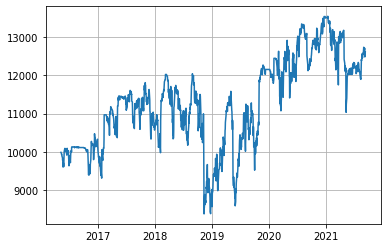

In [40]:
plt.plot(data.index.values, strat.cash_time_series[1:])
plt.grid()